In [1]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model
import pickle
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd

In [37]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

    
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = tf_utils.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc , self.Wo[i,:,:])
            # Dropout.
            proj = tf_utils.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = tf_utils.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


class SpecialTransformer(Layer):
    
    def __init__(self, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.h, self.dk, self.dv, self.dff, self.dropout = h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(SpecialTransformer, self).__init__()

    def build(self, input_shape):
        d = input_shape[0].as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2,), name='beta',
                                 initializer='zeros', trainable=True)
        super(SpecialTransformer, self).build(input_shape)
        
    def call(self, inputs, mask, mask_value=-1e-30):
        query, key, value = inputs
        mask = K.expand_dims(mask, axis=-2)
        # MHA
        mha_ops = []
        for j in range(self.h):
            q = K.dot(query, self.Wq[j,:,:])
            k = K.permute_dimensions(K.dot(key, self.Wk[j,:,:]), (0,2,1))
            v = K.dot(value, self.Wv[j,:,:])
            A = K.batch_dot(q,k)

            # Mask unobserved steps.
            A = mask*A + (1-mask)*mask_value
            # Mask for attention dropout.
            def dropped_A():
                dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                return A*dp_mask + (1-dp_mask)*mask_value
            A = tf_utils.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
            A = K.softmax(A, axis=-1)
            mha_ops.append(K.batch_dot(A,v))
        conc = K.concatenate(mha_ops, axis=-1)   
        proj = K.dot(conc , self.Wo)
        # Dropout.
        proj = tf_utils.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                   lambda: array_ops.identity(proj))
        # Add & LN
        x = value+proj
        mean = K.mean(x, axis=-1, keepdims=True)
        variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        x = (x - mean) / std
        x = x*self.gamma[0] + self.beta[0]
        # FFN
        ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1), self.b1)), 
                       self.W2), self.b2)
        # Dropout.
        ffn_op = tf_utils.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                   lambda: array_ops.identity(ffn_op))
        # Add & LN
        x = x+ffn_op
        mean = K.mean(x, axis=-1, keepdims=True)
        variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        x = (x - mean) / std
        x = x*self.gamma[1] + self.beta[1]   
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape

class MultiTimeAttention(Layer):
    
    def __init__(self, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.h, self.dk, self.dv, self.dff, self.dropout = h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(MultiTimeAttention, self).__init__()

    def build(self, input_shape):
        d = input_shape[0].as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        # self.Wo = self.add_weight(shape=(self.dv*self.h, d), name='Wo',
        #                          initializer='glorot_uniform', trainable=True)
        self.gamma = self.add_weight(shape=(1,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(1,), name='beta',
                                 initializer='zeros', trainable=True)
        super(MultiTimeAttention, self).build(input_shape)
        
    def call(self, inputs, mask, mask_value=-1e-30):
        query, key, value = inputs
        mask = K.expand_dims(mask, axis=-2)
        # MHA
        mha_ops = []
        for j in range(self.h):
            q = K.dot(query, self.Wq[j,:,:])
            k = K.permute_dimensions(K.dot(key, self.Wk[j,:,:]), (0,2,1))
            v = K.dot(value, self.Wv[j,:,:])
            A = K.batch_dot(q,k)

            # Mask unobserved steps.
            A = mask*A + (1-mask)*mask_value
            # Mask for attention dropout.
            def dropped_A():
                dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                return A*dp_mask + (1-dp_mask)*mask_value
            A = tf_utils.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
            A = K.softmax(A, axis=-1)
            mha_ops.append(K.batch_dot(A,v))
        conc = K.concatenate(mha_ops, axis=-1)   
        
        # Dropout.
        conc = tf_utils.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(conc, rate=self.dropout)),\
                                   lambda: array_ops.identity(conc))
        # LN
        mean = K.mean(conc, axis=-1, keepdims=True)
        variance = K.mean(K.square(conc - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        x = (conc - mean) / std
        x = x*self.gamma[0] + self.beta[0] 

        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_modified_strats(D, max_len, V, d, N, he, dropout, forecast=False, with_demo=True):
    if with_demo:
        demo = Input(shape=(D,))
        demo_enc = Dense(2*d, activation='tanh')(demo)
        demo_enc = Dense(d, activation='tanh')(demo_enc)

    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)

    # query = times_emb
    key = Add()([varis_emb, values_emb])
    value = Add()([varis_emb, values_emb, times_emb]) # b, L, d

    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L

    mtand_emb = MultiTimeAttention(he, dk=None, dv=None, dff=None, dropout=dropout)([times_emb, key, value], mask=mask)
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(mtand_emb, mask=mask)

    attn_weights = Attention(2*d)(cont_emb, mask=mask)

    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    if with_demo:
        conc = Concatenate(axis=-1)([fused_emb, demo_enc])
        fore_op = Dense(V)(conc)
        op = Dense(1, activation='sigmoid')(fore_op)
        model = Model([demo, times, values, varis], op)
        if forecast:
            fore_model = Model([demo, times, values, varis], fore_op)
            return [model, fore_model]
    else:
        fore_op = Dense(V)(fused_emb)
        op = Dense(1, activation='sigmoid')(fore_op)
        model = Model([times, values, varis], op)
        if forecast:
            fore_model = Model([times, values, varis], fore_op)
            return [model, fore_model]

    return model


# To tune:
# 1. Transformer parameters. (N, h, dropout)
# 2. Normalization

In [38]:
D, V = 2, 129
lr, batch_size, samples_per_epoch, patience, fore_max_len = 0.0005, 32, 102400, 5, 880
d, N, he, dropout = 32, 2, 4, 0.2
print(f'D: {D}')
print(f'V: {V}')
print(f'd: {d}')
print(f'N: {N}')
print(f'he: {he}')


D: 2
V: 129
d: 32
N: 2
he: 4


In [39]:
model, fore_model =  build_modified_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
print(model.summary())

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 880)]        0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 880)]        0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 880)]        0                                            
__________________________________________________________________________________________________
cve_17 (CVE)                    (None, 880, 32)      170         input_36[0][0]                   
___________________________________________________________________________________________

In [40]:
from tensorflow import keras

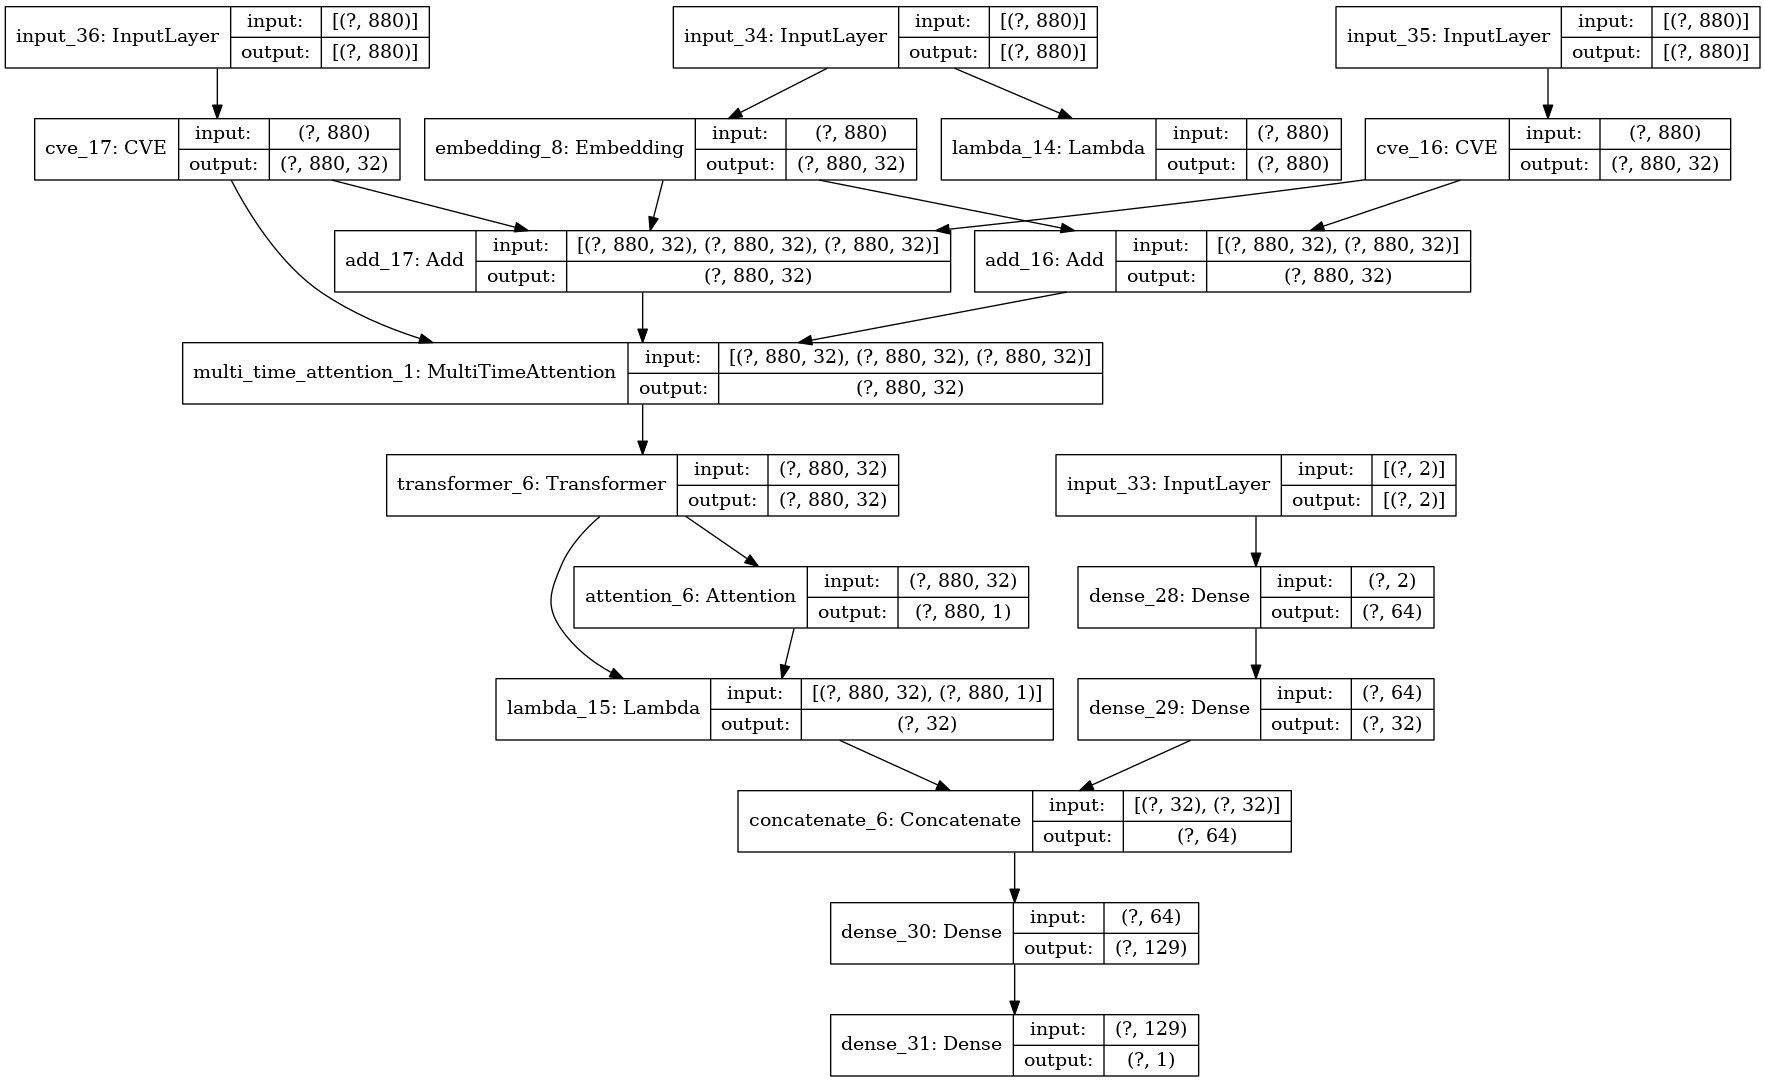

In [41]:
keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)